<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Cross-Validation Lesson

_Authors: Dave Yerrington (SF), Joseph Nelson (DC), Kiefer Katovich (SF)_

---

### Learning Objectives
- **Describe** train/test split and cross-validation.
- **Explain** how these validation techniques differ and why we want to use them.
- **Split** data into testing and training sets using both train/test split and cross-validation and **apply** both techniques to score a model.

### Lesson Guide
- [Overfitting and Underfitting](#overfitting-underfitting)
- [Load the Data](#demo)
- [Train/Test Split and Model Evaluation](#train-test-split)
- [K-Fold Cross-Validation Demonstration](#cross-val-k-fold)
- [Hold-out Sets](#hold-out)
- [Additional Resources](#additional-resources)

<a id='overfitting-underfitting'></a>

## Overfitting and Underfitting

---

![](http://tomrobertshaw.net/img/2015/12/overfitting.jpg)


**What's wrong with the first model?**
- The underfit model falls short of capturing the complexity of the "true model" of the data.

**What's wrong with the third model?**
- The overfit model is too complex and is modeling random noise in the data.

**The middle model is a good compromise.**
- It approximates the complexity of the true model and does not model random noise in our sample as true relationships.

![](http://image.slidesharecdn.com/nncollovcapaldo2013-131220052427-phpapp01/95/machine-learning-introduction-to-neural-networks-12-638.jpg?cb=1393073301)

<a id='demo'></a>

## Load the Data

---

Let's use scikit-learn to load everyone's favorite data set: the Boston housing data.

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

# Load the Boston Housing data set.
boston = datasets.load_boston()
boston.keys()

#
df = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

# Take a look at the data again.
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14


### Plot a Heatmap of the Correlation Matrix

Heatmaps are an effective way to visually examine the correlational structure of your predictors. 

> Keep in mind that Pearson correlation between non-dummy-coded categorical variables and other variables is invalid.

[Plotting a diagonal correlation matrix](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

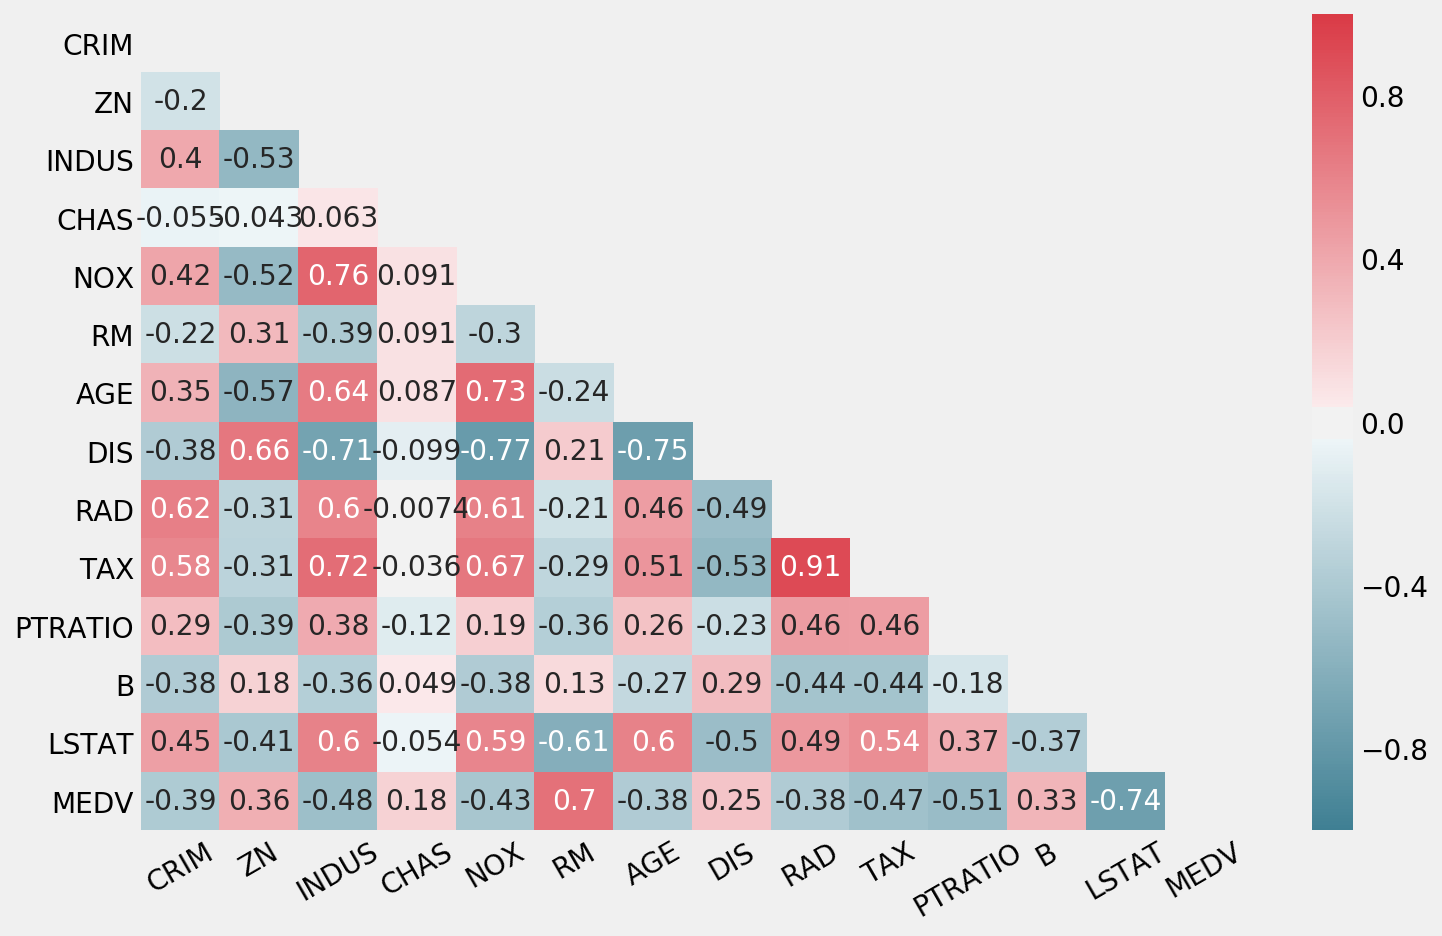

In [9]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(11,7))

    # Generate a mask for the upper triangle (taken from the Seaborn example gallery):
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with Seaborn.
    # Assign the matplotlib axis the function returns. This allow us to resize the labels.
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corrs, mask=mask, annot=True, cmap=cmap, vmin=-1, vmax=1)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

df_with_target = df.copy()
df_with_target['MEDV'] = y
correlation_heat_map(df_with_target)

<a id='single-predictor'></a>

### Select a Single Predictor for an SLR

The variable `AGE` appears to have a minor linear relationship with the target variable `MEDV`.

Let's select `AGE` out of the data as a single-column design matrix.

In [10]:
X = df[['AGE']]
X.head(3)

,AGE
0,65.2
1,78.9
2,61.1


In [ ]:
# A: 
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
model.score(X, y)

**It's good practice to plot the variable against the target to confirm the relationship visually.**

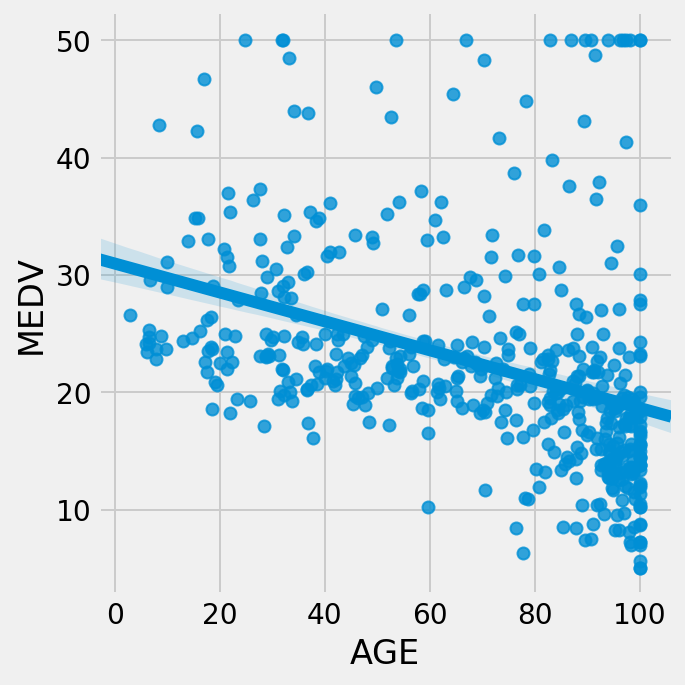

In [13]:
sns.lmplot('AGE','MEDV', df_with_target)

<a name="train-test-split"></a>
## Train/Test Split and Model Validation

---

So far we've focused on fitting the best model to our data. But is this the best model for our sample data or the best model overall? How do we know?

In practice we need to validate our model's ability to generalize to new data. One popular method for performing model validation is by splitting our data into subsets: data on which we *train* our model and data on which we *test* our model.

The most basic type of "hold-out" validation is called **train/test split**. We split our data into two pieces:

> **"A Training Set":** The subset of the data on which we fit our model.

> **"A Testing Set":** The subset of the data on which we evaluate the quality of our predictions.


**Train/Test Split Benefits:**

- Testing data can represent "future" data; for prediction-oriented models, it's critical to ensure that a model that is performing well on current data will likely perform well on future data.
- It can help diagnose and avoid overfitting via model tuning.
- It can improve the quality of our predictions.

<a id='sklearn-tts'></a>

### Scikit-Learn's `train_test_split` Function

Performing train/test splits using scikit-learn is easy — load the `train_test_split` function:

```python
from sklearn.model_selection import train_test_split
```

**Arguments**:
- *Arrays*: Any number of arrays/matrices to split up into training and testing sets (they should be the same length).
- `test_size`: An integer representing the exact size of the testing subset or a float for a percentage.
- `train_size`: Alternatively, you can specify the training size.
- `stratify`: Supply a vector to stratify the splitting (by more important classification tasks).

**Perform a 50-50 split of our `X` and `y`.**

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [38]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(253, 1) (253,)
(253, 1) (253,)


Note that we could always split the data up manually. Here's an example for of manually split code for [this data set](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py).

<a id='fit-on-train'></a>

### Fit a Linear Regression on the Training Set

Using the training `X` and training `y`, we can fit a linear regression with scikit-learn's `LinearRegression`.

In [39]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

<a id='score-on-test'></a>

### Calculate the $R^2$ Score on the Testing Data

After we've constructed our model on the training set, we can evaluate how well it performs on data that it's had no exposure to.

In [40]:
print slr.score(X_test, y_test)

0.125945117072


**Compare this to how the model scored on the training set.**

In [41]:
print slr.score(X_train, y_train)

0.153541480196


<a id='cross-val-k-fold'></a>

## K-Fold Cross-Validation

---

K-fold cross-validation takes the idea of a single train/test split and expands it to *multiple tests* across different train/test splits of your data.

For example, if you determine your training set will contain 80 percent of the data and your testing set will contain the other 20 percent, you could have five different 80/20 splits in which the test set in each is a different set of observations. We have:
- Five (K=5) training sets.
- Five (K=5) corresponding testing sets.

**K-fold cross-validation builds K models — one for each train/test pair — and evaluates those models on each respective test set.**

### K-Fold Cross-Validation Visually

<img src="https://snag.gy/o1lLcw.jpg?convert_to_webp=true" width="500"a>

---

Cross-validation helps us understand how a model parameterization may perform in a variety of cases. The k-fold cross-validation procedure can be described in pseudocode:

```
set k
create k groups of rows in data

for group i in k row groups:
    test data is data[group i]
    train data is data[all groups not i]
    
    fit model on train data
    
    score model on test data
    
evaluate mean of k model scores
evaluate variance of k model scores
```

Odd case No. 1:
> **When K=2**: This is equivalent to performing ***two*** mirror image 50-50 train/test splits.

Odd case No. 2:
> **When K=number of rows**: This is known as "leave-one-out cross-validation," or LOOCV. A model is built on all but one row and tested on the single excluded observation.

### K-Folds Cross Validation in `sklearn`

Now let's try out k-fold cross-validation. Again, scikit-learn provides useful functions to do the heavy lifting. 

The function `cross_val_score` returns the $R^2$ for each testing set. 

Alternatively, the function `cross_val_predict` returns the predicted values for each data point when it's in the testing slice.


Cross-validated scores: [ 0.04495477  0.05074154 -0.69817202 -0.06274528 -1.21254137]
Cross-Predicted R2: 0.0358496432764


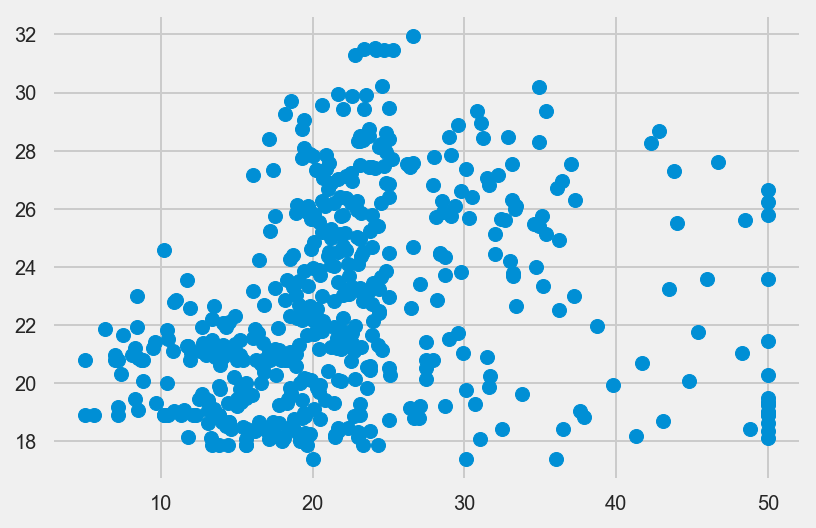

In [44]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform cross-validation with a five-fold split.
scores = cross_val_score(slr, X, y, cv=5)
print("Cross-validated scores:", scores)

# Make cross-validated predictions on the testing sets.
predictions = cross_val_predict(slr, X, y, cv=5)
plt.scatter(y, predictions)

# Manually calculate the R2.
r2 = metrics.r2_score(y, predictions)
print("Cross-Predicted R2:", r2)

<a id='neg-r2'></a>
## Review: Negative $R^2$ Values

---

What does it mean to have a negative $R^2$?

A negative $R^2$ only makes sense (and can only be found) when we're evaluating the $R^2$ score on data on which the model was not fit. If $R^2$ is evaluated for a model using the training data, *the minimum $R^2$ must be zero.* 

However, on a testing set the $R^2$ **can** be negative. This means that the model performs so poorly on the testing set that you would have been better off just using the mean of the target from the training set as an estimate.

<a id='hold-out'></a>

## Hold-Out Sets

---

Hold-out sets are a version of train/test split. To create a hold-out set, you:

1) **Split data into a large training and a small testing set. This small testing set will be the "hold-out" set.**

2) **For a set of different model parameterizations:**

    1) Set up the model.
    2) Cross-validate the current model on the training data.
    3) Save the model performance.

3) **Select the model that performed best using cross-validation on the training data.**

4) **Perform a final test of that model on the original "hold-out" test set.**

> **Note:** The "hold-out" method is more conservative, but also requires you to have more data. With smaller data sets it can be infeasible.

The graphic below explains the hold-out method visually:

![](./assets/Train-Test-Split-CV.png)

<a id='additional-resources'></a>

## Additional Resources

---

- [Cross-Validation Example](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py).
- [Plotting Cross-Validated Predictions](http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html).
- Review this [academic paper](http://frostiebek.free.fr/docs/Machine%20Learning/validation-1.pdf) on the underpinnings of the hold-out method, LOOVC, and k-folds.
- Review the scikit-learn [documentation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) on cross-validation.
- Review this [Stanford lesson](https://www.youtube.com/watch?v=_2ij6eaaSl0) on cross-validation.
- Review this [blog post](http://www.win-vector.com/blog/2015/01/random-testtrain-split-is-not-always-enough/) on why TTS is not always sufficient.
- Review this Stack Exchange [discussion](http://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio) on approximate TTS and validation set sizes.